In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np



crossValidationDataPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Training/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Training/LeftHand_NO_FLIP']
testPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Test/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Test/LeftHand_NO_FLIP']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    


test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-01 07:40:33.029531: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 07:40:33.155066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 07:40:33.155102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 07:40:33.175086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 07:40:33.216959: I tensorflow/core/platform/cpu_feature_guar

[0, 32, 35, 26, 57, 28, 5, 19, 54, 25, 37, 9, 45, 6, 32, 42, 52, 55, 25, 32, 56, 40, 23, 59, 43, 26, 57, 8, 4, 34, 4, 19, 39, 5, 3, 0, 8, 58, 41, 33, 11, 20, 39, 37, 3, 21, 27, 2, 45, 42, 45, 34, 14, 2, 50, 1, 48, 7, 43, 9, 15, 52, 23, 56, 36, 13, 22, 21, 26, 16, 28, 59, 28, 6, 10, 34, 36, 11, 56, 5, 10, 18, 11, 40, 28, 45, 17, 57, 59, 9, 43, 14, 41, 55, 44, 12, 19, 33, 6, 0, 26, 18, 7, 9, 59, 19, 18, 54, 3, 0, 32, 23, 6, 23, 26, 33, 50, 41, 12, 47, 17, 3, 32, 51, 48, 51, 47, 29, 0, 16, 11, 8, 42, 9, 15, 25, 26, 21, 38, 17, 35, 24, 19, 27, 11, 10, 24, 50, 25, 25, 27, 58, 39, 16, 16, 45, 0, 23, 12, 58, 48, 22, 7, 19, 56, 47, 30, 8, 0, 47, 28, 58, 23, 18, 5, 7, 29, 19, 23, 13, 20, 42, 19, 45, 57, 8, 53, 3, 54, 2, 53, 17, 14, 56, 6, 56, 4, 13, 40, 24, 4, 43, 6, 53, 27, 2, 57, 19, 20, 57, 12, 11, 2, 40, 47, 7, 51, 23, 31, 34, 18, 25, 24, 7, 0, 27, 59, 13, 10, 11, 24, 41, 13, 59, 0, 2, 26, 53, 1, 21, 2, 1, 11, 18, 39, 21, 20, 33, 10, 15, 2, 32, 51, 55, 1, 9, 24, 44, 6, 30, 56, 44, 41, 23, 7

In [5]:


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
   
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-01 07:40:37.567572: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-01 07:40:37.567591: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-01 07:40:37.567594: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-01 07:40:37.567682: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-01 07:40:37.567693: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-01 07:40:37.567695: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704073246.425883  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.7559 - accuracy: 0.0953

W0000 00:00:1704073254.371055  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 70ms/step - loss: 3.7559 - accuracy: 0.0953 - val_loss: 3.2245 - val_accuracy: 0.2500
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0357 - accuracy: 0.2427 - val_loss: 2.5588 - val_accuracy: 0.4005
Epoch 3/200
113/113 [==============================] - 7s 58ms/step - loss: 2.5624 - accuracy: 0.3530 - val_loss: 2.1308 - val_accuracy: 0.5585
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.2349 - accuracy: 0.4252 - val_loss: 1.7975 - val_accuracy: 0.6244
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0283 - accuracy: 0.4749 - val_loss: 1.6494 - val_accuracy: 0.6468
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 1.8129 - accuracy: 0.5373 - val_loss: 1.4522 - val_accuracy: 0.6878
Epoch 7/200
113/113 [==============================] - 6s 57ms/step - loss: 1.6596 - accuracy: 0.5729 - val_loss: 1.3202 - val_accuracy: 0.7264
Epo

W0000 00:00:1704073941.472713  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9701492537313433
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5869905956112853
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704073950.906736  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8513 - accuracy: 0.0819

W0000 00:00:1704073958.109303  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.8513 - accuracy: 0.0819 - val_loss: 3.5453 - val_accuracy: 0.1420
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.2542 - accuracy: 0.1937 - val_loss: 2.9030 - val_accuracy: 0.3088
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7765 - accuracy: 0.2995 - val_loss: 2.4085 - val_accuracy: 0.4147
Epoch 4/200
113/113 [==============================] - 7s 60ms/step - loss: 2.4281 - accuracy: 0.3832 - val_loss: 2.0443 - val_accuracy: 0.5529
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1531 - accuracy: 0.4494 - val_loss: 1.8263 - val_accuracy: 0.6102
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9566 - accuracy: 0.4960 - val_loss: 1.5857 - val_accuracy: 0.6600
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.7942 - accuracy: 0.5349 - val_loss: 1.4308 - val_accuracy: 0.7148
Epoc

W0000 00:00:1704074517.103794  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 2: 0.9726027397260274
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.585423197492163
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704074525.388470  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.7604 - accuracy: 0.0932

W0000 00:00:1704074532.688407  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 65ms/step - loss: 3.7604 - accuracy: 0.0932 - val_loss: 3.2662 - val_accuracy: 0.2167
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.0996 - accuracy: 0.2079 - val_loss: 2.7127 - val_accuracy: 0.3562
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.7033 - accuracy: 0.3022 - val_loss: 2.2853 - val_accuracy: 0.4732
Epoch 4/200
113/113 [==============================] - 7s 60ms/step - loss: 2.3878 - accuracy: 0.3747 - val_loss: 1.9943 - val_accuracy: 0.5492
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.1696 - accuracy: 0.4265 - val_loss: 1.7654 - val_accuracy: 0.6600
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 1.9718 - accuracy: 0.4810 - val_loss: 1.5521 - val_accuracy: 0.6849
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 1.7985 - accuracy: 0.5255 - val_loss: 1.4131 - val_accuracy: 0.7024
Epo

W0000 00:00:1704075219.632112  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 14ms/step
Validation Accuracy Fold 3: 0.9788293897882939
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6230407523510971
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704075228.021077  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.7945 - accuracy: 0.0854

W0000 00:00:1704075235.277069  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 65ms/step - loss: 3.7945 - accuracy: 0.0854 - val_loss: 3.2587 - val_accuracy: 0.2279
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.0683 - accuracy: 0.2239 - val_loss: 2.6471 - val_accuracy: 0.3325
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.6621 - accuracy: 0.3124 - val_loss: 2.2566 - val_accuracy: 0.4583
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3678 - accuracy: 0.3748 - val_loss: 1.9646 - val_accuracy: 0.5455
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.0911 - accuracy: 0.4481 - val_loss: 1.7138 - val_accuracy: 0.6040
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9223 - accuracy: 0.4893 - val_loss: 1.5608 - val_accuracy: 0.6575
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 1.7825 - accuracy: 0.5343 - val_loss: 1.3704 - val_accuracy: 0.7210
Epo

W0000 00:00:1704075958.654764  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9813200498132005
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5807210031347962
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704075967.078964  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8020 - accuracy: 0.0876

W0000 00:00:1704075974.308860  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 65ms/step - loss: 3.8020 - accuracy: 0.0876 - val_loss: 3.3327 - val_accuracy: 0.2229
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.1414 - accuracy: 0.2196 - val_loss: 2.6933 - val_accuracy: 0.3910
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.6426 - accuracy: 0.3289 - val_loss: 2.1797 - val_accuracy: 0.5380
Epoch 4/200
113/113 [==============================] - 7s 60ms/step - loss: 2.2451 - accuracy: 0.4268 - val_loss: 1.8264 - val_accuracy: 0.6276
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 1.9738 - accuracy: 0.4888 - val_loss: 1.5598 - val_accuracy: 0.7073
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 1.7629 - accuracy: 0.5429 - val_loss: 1.3760 - val_accuracy: 0.7223
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 1.5961 - accuracy: 0.5861 - val_loss: 1.2212 - val_accuracy: 0.7646
Epoc

W0000 00:00:1704076685.175326  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.9701120797011208
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6089341692789969
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704076693.993082  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8548 - accuracy: 0.0764

W0000 00:00:1704076701.548712  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 68ms/step - loss: 3.8548 - accuracy: 0.0764 - val_loss: 3.4515 - val_accuracy: 0.1569
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.2205 - accuracy: 0.2013 - val_loss: 2.8312 - val_accuracy: 0.3188
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7896 - accuracy: 0.2879 - val_loss: 2.5157 - val_accuracy: 0.4222
Epoch 4/200
113/113 [==============================] - 7s 60ms/step - loss: 2.5094 - accuracy: 0.3568 - val_loss: 2.1477 - val_accuracy: 0.5106
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2608 - accuracy: 0.4156 - val_loss: 1.9363 - val_accuracy: 0.5716
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0779 - accuracy: 0.4768 - val_loss: 1.7723 - val_accuracy: 0.6052
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9038 - accuracy: 0.5036 - val_loss: 1.5868 - val_accuracy: 0.6737
Epo

W0000 00:00:1704077381.733032  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 6: 0.9800747198007472
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5987460815047022
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704077390.532431  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8615 - accuracy: 0.0804

W0000 00:00:1704077398.249848  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 69ms/step - loss: 3.8615 - accuracy: 0.0804 - val_loss: 3.4159 - val_accuracy: 0.2130
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.2110 - accuracy: 0.2169 - val_loss: 2.8239 - val_accuracy: 0.3400
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.7794 - accuracy: 0.3052 - val_loss: 2.3949 - val_accuracy: 0.4670
Epoch 4/200
113/113 [==============================] - 7s 61ms/step - loss: 2.4600 - accuracy: 0.3860 - val_loss: 2.0860 - val_accuracy: 0.5567
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.2074 - accuracy: 0.4462 - val_loss: 1.8347 - val_accuracy: 0.6314
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 1.9924 - accuracy: 0.4942 - val_loss: 1.6585 - val_accuracy: 0.6426
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 1.8358 - accuracy: 0.5379 - val_loss: 1.4947 - val_accuracy: 0.6949
Epo

W0000 00:00:1704078278.970092  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9800747198007472
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5869905956112853
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704078287.794592  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.7757 - accuracy: 0.1002

W0000 00:00:1704078295.389747  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 68ms/step - loss: 3.7757 - accuracy: 0.1002 - val_loss: 3.2970 - val_accuracy: 0.2565
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0654 - accuracy: 0.2472 - val_loss: 2.6467 - val_accuracy: 0.4147
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6033 - accuracy: 0.3367 - val_loss: 2.1875 - val_accuracy: 0.5106
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3006 - accuracy: 0.4112 - val_loss: 1.9132 - val_accuracy: 0.5853
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0248 - accuracy: 0.4830 - val_loss: 1.6187 - val_accuracy: 0.6700
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 1.8355 - accuracy: 0.5221 - val_loss: 1.4788 - val_accuracy: 0.7086
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 1.6654 - accuracy: 0.5617 - val_loss: 1.3016 - val_accuracy: 0.7497
Epo

W0000 00:00:1704079087.466312  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 8: 0.9713574097135741
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6018808777429467
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704079096.521040  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8688 - accuracy: 0.0715

W0000 00:00:1704079104.356703  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 70ms/step - loss: 3.8688 - accuracy: 0.0715 - val_loss: 3.4866 - val_accuracy: 0.1582
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.2182 - accuracy: 0.2048 - val_loss: 2.8256 - val_accuracy: 0.3611
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 2.7202 - accuracy: 0.3131 - val_loss: 2.3649 - val_accuracy: 0.4981
Epoch 4/200
113/113 [==============================] - 7s 60ms/step - loss: 2.3668 - accuracy: 0.3985 - val_loss: 2.0544 - val_accuracy: 0.5592
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 2.1130 - accuracy: 0.4566 - val_loss: 1.8059 - val_accuracy: 0.6065
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 1.8945 - accuracy: 0.5119 - val_loss: 1.6265 - val_accuracy: 0.6488
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 1.7528 - accuracy: 0.5466 - val_loss: 1.4310 - val_accuracy: 0.6949
Epo

W0000 00:00:1704079994.325860  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 9: 0.9676214196762142
40/40 [==============================] - 1s 14ms/step
Test - Accuracy: 0.6183385579937304
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704080003.325492  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8663 - accuracy: 0.0718

W0000 00:00:1704080010.950364  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 69ms/step - loss: 3.8663 - accuracy: 0.0718 - val_loss: 3.4533 - val_accuracy: 0.2030
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3101 - accuracy: 0.1944 - val_loss: 2.9218 - val_accuracy: 0.3126
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.9374 - accuracy: 0.2737 - val_loss: 2.5906 - val_accuracy: 0.4110
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6630 - accuracy: 0.3392 - val_loss: 2.2951 - val_accuracy: 0.4969
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4431 - accuracy: 0.3767 - val_loss: 2.0694 - val_accuracy: 0.5417
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2475 - accuracy: 0.4267 - val_loss: 1.8511 - val_accuracy: 0.6015
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0833 - accuracy: 0.4647 - val_loss: 1.6849 - val_accuracy: 0.6339
Epo

W0000 00:00:1704080977.248041  521258 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9701120797011208
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6332288401253918
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.5869905956112853, 0.585423197492163, 0.6230407523510971, 0.5807210031347962, 0.6089341692789969, 0.5987460815047022, 0.5869905956112853, 0.6018808777429467, 0.6183385579937304, 0.6332288401253918]
0.6024294670846396
[0.9701492537313433, 0.9726027397260274, 0.9788293897882939, 0.9813200498132005, 0.9701120797011208, 0.9800747198007472, 0.9800747198007472, 0.9713574097135741, 0.9676214196762142, 0.9701120797011208]
0.974225386145239


test accuracies:  [0.5869905956112853, 0.585423197492163, 0.6230407523510971, 0.5807210031347962, 0.6089341692789969, 0.5987460815047022, 0.5869905956112853, 0.6018808777429467, 0.6183385579937304, 0.6332288401253918] 9
validation accuracies:  [0.9701492537313433, 0.9726027397260274, 0.9788293897882939, 0.9813200498132005, 0.9701120797011208, 0.9800747198007472, 0.9800747198007472, 0.9713574097135741, 0.9676214196762142, 0.9701120797011208]
60


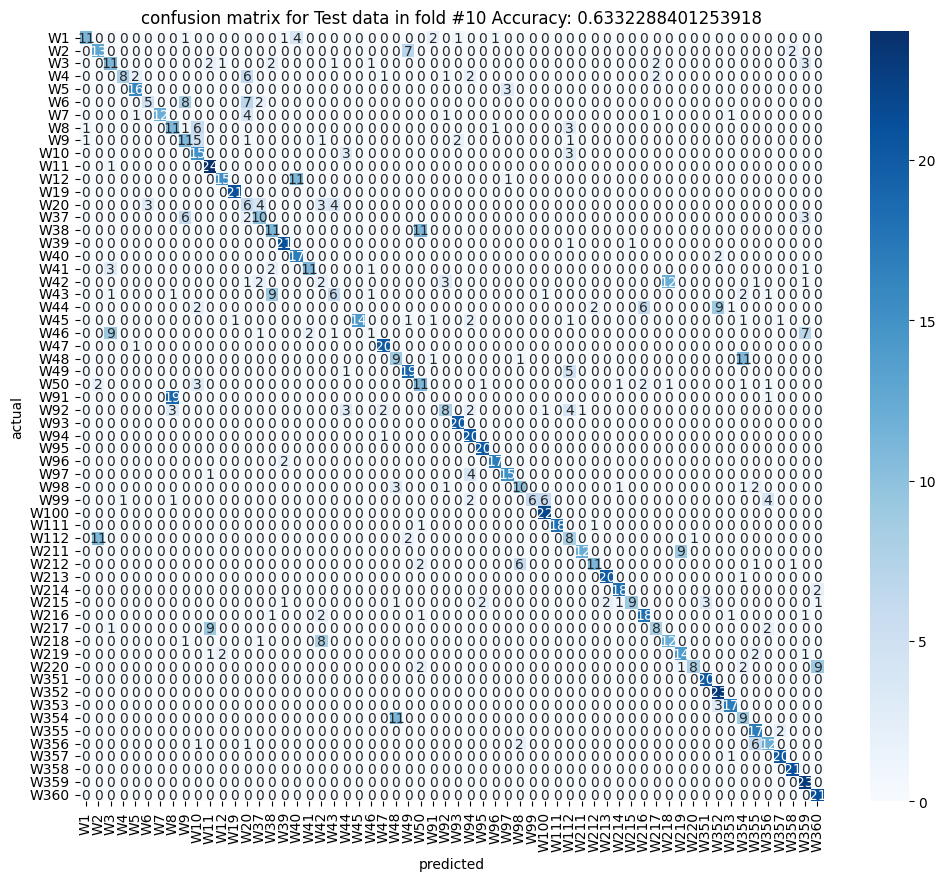

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

